# Extracting data, downloading and reading the last Fenabrave .pdf file

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pypdf import PdfReader
import pdfplumber
from datetime import datetime
%matplotlib inline

base_url = 'https://www.fenabrave.org.br/portal/files/'

# creating variables and url
previous_month = (datetime.now().month - 1) % 12
formatted_month = f'{previous_month:02d}'

pdfpath = r'C:/Users/vinig/OneDrive/Documentos/PdfDataExtraction/pdf/'
filename = f'2024_{formatted_month}_02.pdf'

download_url = base_url + filename
filepath = os.path.join(pdfpath, filename)

# downloading the most updated file (last month).pdf
try:
    response = requests.get(download_url)
    response.raise_for_status()
    
    with open(filepath, 'wb') as file:
        file.write(response.content)
    print(f'downloaded: {filename}')

except requests.exceptions.HTTPError as http_err:
    print(f'http error occurred: {http_err}')

# to use in date columns
file_date = os.path.splitext(os.path.basename(filepath))[0]
file_date = file_date.replace('_', '-')  # date format will be: 'YYYY-MM-DD'

text_list = []
# open the pdf and extracting text from each page
with pdfplumber.open(filepath) as pdf:
    for i in range(10, 16):
        page = pdf.pages[i]
        text = page.extract_text()
        text_list.append(text)

combined_text = "\n".join(text_list)
print (combined_text)

# function to fix special chars(cid:xx) 
def cidToChar(cidx):
    return chr(int(re.findall(r'\(cid\:(\d+)\)',cidx)[0]) + 29)
def replace_cid(text):
    text = re.sub(r'\(cid\:\d+\)', lambda m: cidToChar(m.group(0)), text)
    text = text.replace('»', 'º')
    text = re.sub(r' É|É ', '', text)  
    return text

processed_text = replace_cid(combined_text)

downloaded: 2024_08_02.pdf
Ed. 260
Informativo - Emplacamentos
São Paulo, Setembro de 2024
Modelos mais emplacados acumulado até Ago/2024
AUTOMÓVEIS
Veículos de Entrada
2024 2024 2024
Modelo Part.
Jul Ago Acumulado
1º FIAT/MOBI 6.807 4.771 43.812 56,42%
2º RENAULT/KWID 3.520 4.622 33.775 43,50%
3º VW/GOL 3 7 40 0,05%
4º FIAT/UNO 3 1 11 0,01%
5º VW/UP 1 0 4 0,01%
6º GM/CHEVETTE 0 0 = 3 0,00%
7º FIAT/PALIO 0 0 = 2 0,00%
8º GM/CELTA 0 1 2 0,00%
9º FORD/KA 0 0 = 1 0,00%
Total 10.334 9.403 77.652 100%
Hatch Pequenos
2024 2024 2024
Modelo Part.
Jul Ago Acumulado
1º VW/POLO 12.542 14.274 84.678 24,44%
2º GM/ONIX 7.422 9.018 60.043 17,33%
3º HYUNDAI/HB20 7.228 7.103 57.026 16,46%
4º FIAT/ARGO 8.663 7.768 56.052 16,18%
5º TOYOTA/YARIS HB 2.819 2.392 17.524 5,06%
6º PEUGEOT/208 2.369 1.914 14.152 4,08%
7º CITROEN/C3 2.111 1.899 14.140 4,08%
8º BYD/DOLPHIN MINI 1.488 2.298 12.834 3,70%
9º BYD/DOLPHIN 1.466 1.056 12.128 3,50%
10º HONDA/CITY HATCH 1.590 1.543 8.807 2,54%
11º GWM/ORA 03 398 382 4.46

In [3]:
# use regex to find all occurrences between '1ª and Total' 
matches = re.findall(r'1º.*?Total', processed_text, re.DOTALL)

appended_text = "\n".join(matches)
entries = appended_text.split('\n')

df = pd.DataFrame(entries)

# remove 'Total' rows
drop_patterns = ['Total','=']
drop_regex = '|'.join(drop_patterns)

df = df[~df[0].str.contains(drop_regex, na=False)]

print(df)

                                                0
0          1º FIAT/MOBI 6.807 4.771 43.812 56,42%
1       2º RENAULT/KWID 3.520 4.622 33.775 43,50%
2                          3º VW/GOL 3 7 40 0,05%
3                        4º FIAT/UNO 3 1 11 0,01%
4                            5º VW/UP 1 0 4 0,01%
..                                            ...
144       36º PORSCHE/CAYENNE 175 155 1.169 0,20%
145        37º GM/TRAILBLAZER 173 176 1.163 0,20%
146           38º PEUGEOT/2008 23 364 1.126 0,20%
147  39º LAND ROVER/DISCOVERY 150 124 1.107 0,19%
148                40º BMW/X3 151 179 1.057 0,18%

[121 rows x 1 columns]


## Feature Engineering

In [6]:
# splitting the original dataframe in 2 to make data cleaning easier
def last_4_values(text):
    parts = text.split(' ')
    return parts[-4:]

def remove_last_4_values(text):
    parts = text.split(' ')
    return ' '.join(parts[:-4]) 

df[['last_month', 'emplacados', 'acumulado_anual', 'market_share']] = df.iloc[:,0].apply(lambda x: pd.Series(last_4_values(x)))

df.iloc[:,0] = df.iloc[:,0].apply(remove_last_4_values)

df.columns = ['marca_carro', 'last_month', 'emplacados', 'acumulado_anual', 'market_share']
values_df = df[['last_month', 'emplacados', 'acumulado_anual', 'market_share']].copy()

df = df.drop(columns=['last_month', 'emplacados', 'acumulado_anual', 'market_share'])

# Optional: Display the DataFrames to verify
print('df:')
print(df)
print('\nvalues_df:')
print(values_df)

df:
                  marca_carro
0                1º FIAT/MOBI
1             2º RENAULT/KWID
2                   3º VW/GOL
3                 4º FIAT/UNO
4                    5º VW/UP
..                        ...
144       36º PORSCHE/CAYENNE
145        37º GM/TRAILBLAZER
146          38º PEUGEOT/2008
147  39º LAND ROVER/DISCOVERY
148                40º BMW/X3

[121 rows x 1 columns]

values_df:
    last_month emplacados acumulado_anual market_share
0        6.807      4.771          43.812       56,42%
1        3.520      4.622          33.775       43,50%
2            3          7              40        0,05%
3            3          1              11        0,01%
4            1          0               4        0,01%
..         ...        ...             ...          ...
144        175        155           1.169        0,20%
145        173        176           1.163        0,20%
146         23        364           1.126        0,20%
147        150        124           1.107        0

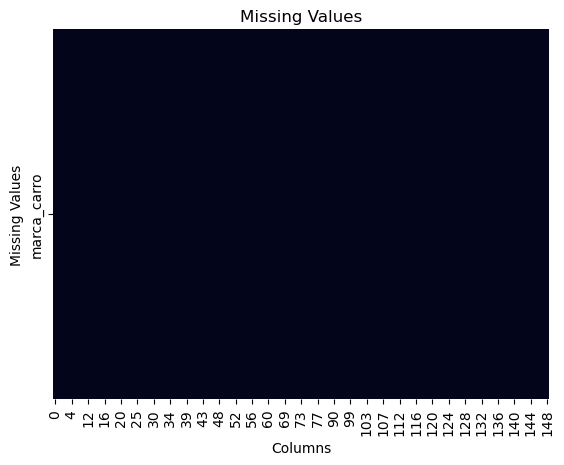

       marca_carro
0     1º FIAT/MOBI
1  2º RENAULT/KWID
2        3º VW/GOL
3      4º FIAT/UNO
4         5º VW/UP


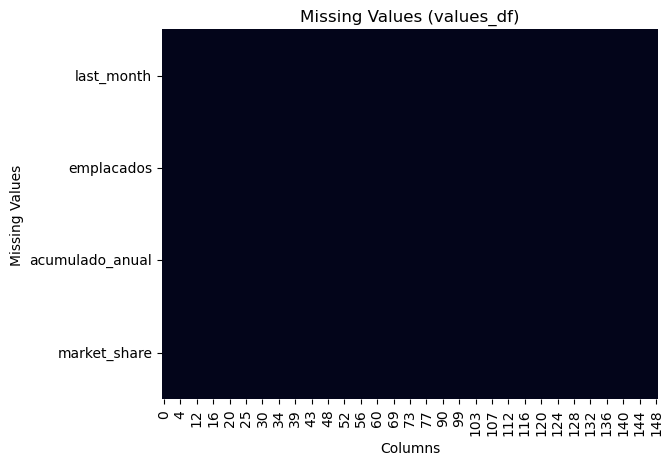

  last_month emplacados acumulado_anual market_share
0      6.807      4.771          43.812       56,42%
1      3.520      4.622          33.775       43,50%
2          3          7              40        0,05%
3          3          1              11        0,01%
4          1          0               4        0,01%


In [8]:
# using heatmap to see if dataframe disribution and, missing values

ax = plt.axes()
sns.heatmap(df.isna().transpose(), cbar=False, ax=ax)
plt.title('Missing Values', fontsize=12)
plt.xlabel('Columns', fontsize = 10) 
plt.ylabel('Missing Values', fontsize = 10)
plt.show()

print(df.head())

# using heatmap to see if dataframe disribution and, missing values

ax = plt.axes()
sns.heatmap(values_df.isna().transpose(), cbar=False, ax=ax)
plt.title('Missing Values (values_df)', fontsize=12)
plt.xlabel('Columns', fontsize = 10) 
plt.ylabel('Missing Values', fontsize = 10)
plt.show()

print(values_df.head())

In [10]:
# cleaning the df, dropping the position value and splitting the [brand/car name0 name1] in [brand] and [car_name0_name1]
df['marca_carro'] = df['marca_carro'].str.replace(r'\d+º', '', regex=True)

df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

df['marca_carro'] = df['marca_carro'].str.replace(' ', '_')

df[['marca', 'modelo']] = df['marca_carro'].str.split('/', expand=True)

df = df.drop(columns=['marca_carro'])

print(df)

          marca       modelo
0          FIAT         MOBI
1       RENAULT         KWID
2            VW          GOL
3          FIAT          UNO
4            VW           UP
..          ...          ...
144     PORSCHE      CAYENNE
145          GM  TRAILBLAZER
146     PEUGEOT         2008
147  LAND_ROVER    DISCOVERY
148         BMW           X3

[121 rows x 2 columns]


In [12]:
# cleaning values_df dataframe, removing dots and dropping last_month and market_share columns (will be created later in DataViz)
values_df = values_df.map(lambda x: x.replace('.', '') if isinstance(x, str) else x)

values_df = values_df.drop(columns=['last_month', 'market_share'])

print(values_df)

    emplacados acumulado_anual
0         4771           43812
1         4622           33775
2            7              40
3            1              11
4            0               4
..         ...             ...
144        155            1169
145        176            1163
146        364            1126
147        124            1107
148        179            1057

[121 rows x 2 columns]


In [14]:
# concatenate the two cleaned and transformed dataframes (df and values_df)
df_final = pd.concat([df, values_df], axis=1)

# using file_date created in the 1st cell
df_final['data'] = file_date

print(df_final)

          marca       modelo emplacados acumulado_anual        data
0          FIAT         MOBI       4771           43812  2024-08-02
1       RENAULT         KWID       4622           33775  2024-08-02
2            VW          GOL          7              40  2024-08-02
3          FIAT          UNO          1              11  2024-08-02
4            VW           UP          0               4  2024-08-02
..          ...          ...        ...             ...         ...
144     PORSCHE      CAYENNE        155            1169  2024-08-02
145          GM  TRAILBLAZER        176            1163  2024-08-02
146     PEUGEOT         2008        364            1126  2024-08-02
147  LAND_ROVER    DISCOVERY        124            1107  2024-08-02
148         BMW           X3        179            1057  2024-08-02

[121 rows x 5 columns]


In [16]:
# see whole DF
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(df_final)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

num_rows, num_col = df_final.shape

print(f'Rows: {num_rows}')
print(f'Columns: {num_col}')

          marca         modelo emplacados acumulado_anual        data
0          FIAT           MOBI       4771           43812  2024-08-02
1       RENAULT           KWID       4622           33775  2024-08-02
2            VW            GOL          7              40  2024-08-02
3          FIAT            UNO          1              11  2024-08-02
4            VW             UP          0               4  2024-08-02
7            GM          CELTA          1               2  2024-08-02
10           VW           POLO      14274           84678  2024-08-02
11           GM           ONIX       9018           60043  2024-08-02
12      HYUNDAI           HB20       7103           57026  2024-08-02
13         FIAT           ARGO       7768           56052  2024-08-02
14       TOYOTA       YARIS_HB       2392           17524  2024-08-02
15      PEUGEOT            208       1914           14152  2024-08-02
16      CITROEN             C3       1899           14140  2024-08-02
17          BYD   DO

In [18]:
filename_tosave = os.path.splitext(filename)[0]

#.csv Save
csv_filepath =fr'C:/Users/vinig/OneDrive/Documentos/PdfDataExtraction/data/data{filename_tosave}.csv'

df_final.to_csv(csv_filepath, index=False, encoding='ISO-8859-1')

print(f'data.csv saved to {csv_filepath}')

data.csv saved to C:/Users/vinig/OneDrive/Documentos/PdfDataExtraction/data/data2024_08_02.csv


## LOAD data into AWS RDS and query the table to verify if the data is properly loaded

In [21]:
import sys
import os

csv_path = fr'C:/Users/vinig/OneDrive/Documentos/PdfDataExtraction/data/data{filename_tosave}.csv'

# Example usage for testing directly
user = ''
password = ''
host = 'fenabraveetl.c180cksc69a7.us-east-1.rds.amazonaws.com'
port = '5432'  # Default port for PostgreSQL
database = ''
table_name = 'processed_test'

# Add the path of the 'scripts' directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Import the load_data_to_rds function from the loaddata.py script
from loaddata import load_data_to_rds

# Call the function to load data into RDS
load_data_to_rds(csv_path, user, password, host, port, database, table_name)


Data loaded from C:/Users/vinig/OneDrive/Documentos/PdfDataExtraction/data/data2024_08_02.csv
Connected to the database!
Data loaded into table 'processed_data'
Data from the table:
           marca       modelo  emplacados  acumulado_anual        data
0           FIAT         MOBI        3719             3719  2024-01-02
1        RENAULT         KWID        3096             3096  2024-01-02
2             VW          GOL           8                8  2024-01-02
3           FIAT          UNO           2                2  2024-01-02
4           FIAT        PALIO           1                1  2024-01-02
...          ...          ...         ...              ...         ...
4137     PORSCHE      CAYENNE         155             1169  2024-08-02
4138          GM  TRAILBLAZER         176             1163  2024-08-02
4139     PEUGEOT         2008         364             1126  2024-08-02
4140  LAND_ROVER    DISCOVERY         124             1107  2024-08-02
4141         BMW           X3        